In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from keras.models import Sequential, Model 
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


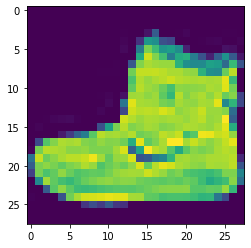

In [3]:
plt.imshow(x_train[0])

In [4]:
x_train = np.expand_dims(x_train, axis=3)

In [5]:
x_train[0].shape

(28, 28, 1)

In [6]:
def create_generator():
  model = Sequential()

  model.add(Dense(256, input_dim=100))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1)))
    
  model.summary()

  noise = Input(shape=(100,))
  img = model(noise)

  return Model(noise, img)

generator = create_generator()
z = Input(shape=(100,))
img = generator(z)





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)         

In [7]:
def create_discriminator():
    
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(28, 28, 1))
  validity = model(img)

  return Model(img, validity)

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

In [8]:
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

C:\Users\kkopperla\AppData\Local\Continuum\anaconda2\envs\py37\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.645745, acc.: 76.56%] [G loss: 0.792063]


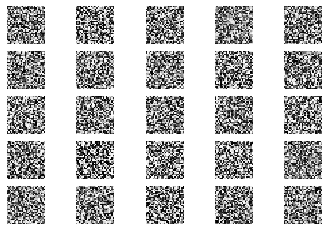

C:\Users\kkopperla\AppData\Local\Continuum\anaconda2\envs\py37\lib\site-packages\keras\engine\training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.303738, acc.: 84.38%] [G loss: 0.837256]
2 [D loss: 0.302474, acc.: 82.81%] [G loss: 0.844208]
3 [D loss: 0.236958, acc.: 93.75%] [G loss: 0.874879]
4 [D loss: 0.298326, acc.: 87.50%] [G loss: 0.961732]
5 [D loss: 0.237451, acc.: 92.19%] [G loss: 1.031243]
6 [D loss: 0.231370, acc.: 93.75%] [G loss: 1.106586]
7 [D loss: 0.227131, acc.: 96.88%] [G loss: 1.115691]
8 [D loss: 0.171255, acc.: 100.00%] [G loss: 1.188038]
9 [D loss: 0.180231, acc.: 100.00%] [G loss: 1.229495]


In [10]:
epochs = 10

batch_size = 32
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  #discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

  #generator
  noise = np.random.normal(0, 1, (batch_size, 100))

  g_loss = combined.train_on_batch(noise, valid)

  print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

  if epoch % 50 == 0:
    sample_images(epoch)

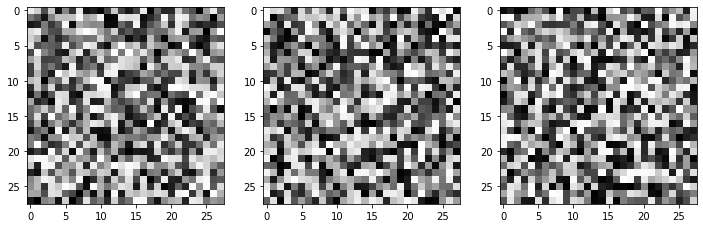

In [11]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r*c, 100))
gen_imgs = generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.subplot(132)
plt.imshow(gen_imgs[1, :, :, 0], cmap='gray')
plt.subplot(133)
plt.imshow(gen_imgs[2, :, :, 0], cmap='gray')
plt.show()
plt.close()